### Import necessary libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
#pip install tqdm

In [35]:
import unicodedata
import nltk
import string
from tqdm import tqdm
from time import time

### Load the dataset

In [36]:
df_train = pd.read_csv('OLIDv1.0/olid-training-v1.0.tsv', sep = '\t')
df_train.columns = ['id', 'tweet', 'sentiment', 'targetted_or_not', 'target_type']

In [37]:
df_train.head()

,id,tweet,sentiment,targetted_or_not,target_type
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


**sentiment column:**  
1 indicates offensive tweet, 0 indicates not offensive.

**targetted_or_not column:**   
1 indicates targetted tweet, 0 indicates that the tweet is not targetted.  
This column has a meaningful value only when the tweet is offensive.  
                         
**target_type:**   
If the tweet is offensive and targetted,  
1 indicates that the target is an individual  
2 indicates that the target is a group  
3 indicates some other target  
When the tweet is not offensive or offensive but untargetted, there is no meaningful value.

#### Change the text labels to numeric labels

In [38]:
dict_labels = {"OFF": 1, "NOT": 0,
               "TIN": 1, "UNT": 0,
               "IND": 1, "GRP": 2, "OTH": 3}

In [39]:
def convert_labels(x):
    if x in dict_labels.keys():
        return dict_labels[x]
    else:
        return None

#### Sentiment
* OFF = Offensive  
* NOT = Not offensive

NOT    8840
OFF    4400
Name: sentiment, dtype: int64


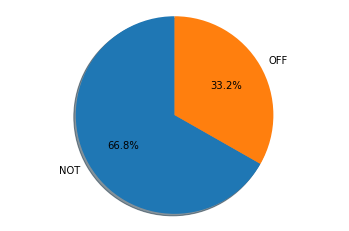

In [40]:
val_counts = df_train['sentiment'].value_counts()
print(val_counts)

labels = val_counts.keys()
sizes = val_counts.values
explode = (0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

df_train['sentiment'] = df_train['sentiment'].apply(lambda x: dict_labels[x])

#### Targetted or Not Targetted

* TIN = Targetted  
* UNT = Not targetted

TIN    3876
UNT     524
Name: targetted_or_not, dtype: int64


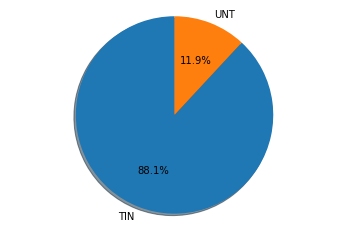

In [41]:
val_counts = df_train['targetted_or_not'].value_counts()
print(val_counts)

labels = val_counts.keys()
sizes = val_counts.values
explode = (0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

df_train['targetted_or_not'] = df_train['targetted_or_not'].apply(convert_labels)

#### Target type
* IND = Individual
* GRP = Group
* OTH = Other

IND    2407
GRP    1074
OTH     395
Name: target_type, dtype: int64


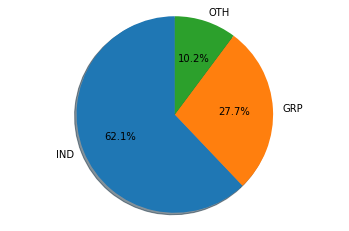

In [42]:
val_counts = df_train['target_type'].value_counts()
print(val_counts)

labels = val_counts.keys()
sizes = val_counts.values
explode = (0, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

df_train['target_type'] = df_train['target_type'].apply(convert_labels)

## Preprocessing

In [43]:
df_train.head()

,id,tweet,sentiment,targetted_or_not,target_type
0,86426,@USER She should ask a few native Americans wh...,1,0.0,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,1.0,1.0
2,16820,Amazon is investigating Chinese employees who ...,0,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",1,0.0,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,0,NaN,NaN


#### Converting to Lowercase and Removing Punctuation

In [44]:
from nltk.tokenize import word_tokenize, TweetTokenizer

def my_word_tokenize(doc):
    new_doc = ""
    characters_to_remove = string.punctuation.replace("'", "") + "\n"
    new_doc = ''.join([ch if ch not in characters_to_remove else " " for ch in doc])
    return new_doc.split()

def basic_preprocess(doc):
    '''
    Input: doc (A comment, which is string)
    Output: List of words in the preprocessed document
    Basic preprocessing includes:
    a) converting to lowercase
    b) removing newline characters
    c) removing all punctuation
    d) normalizing to NFKC form
    '''
    
    # Normalization and conversiom to lowercase
    doc = unicodedata.normalize('NFKC', doc).lower()

    # A list of all the words in the document after removing punctuation.
    tokens = my_word_tokenize(doc)
    return tokens

def basic_preprocess_1(doc):
    '''
    Input: doc (A comment, which is string)
    Output: List of words in the preprocessed document
    Basic preprocessing includes:
    a) converting to lowercase
    b) removing newline characters
    c) removing all punctuation
    d) normalizing to NFKC form
    '''
    
    # Normalization and conversiom to lowercase
    doc = unicodedata.normalize('NFKC', doc).lower()
    doc = doc.replace('_', ' ')
    
    # A list of all the words in the document after removing punctuation.
    #tokens = word_tokenize(doc)
    tokens = TweetTokenizer().tokenize(doc)
    # Maps all punctuation marks to 'None'
    table = str.maketrans('', '', string.punctuation.replace('@', '').replace("'", ""))
    # Removes the punctuation marks from each word, if present.
    stripped = [w.translate(table) for w in tokens]
    stripped = [w for w in stripped if w!='']
    return stripped

#### Lemmatization

In [45]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import  wordnet

def get_wordnet_pos(treebank_tag):
    '''
    This function is used to convert the Part of Speech tags returned by nltk.pos_tag
    function to the wordnet POS tags.
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        # Instead of returning None, I am returning the noun tag, because, by default
        # the WordNetLemmatizer assumes that the POS tag is noun.
        
def lemmatize(doc_words):
    '''
    Input: doc(A comment)
    Output: A list of words in the document,after lemmatization
    '''
    # Creating Part-of-Speech tags for the words
    pos_tags = nltk.pos_tag(doc_words)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lem_words = [lemmatizer.lemmatize(word, pos = get_wordnet_pos(tag)) for word, tag in pos_tags]
    return lem_words

#### Removing Stopwords

In [46]:
# Removal of stopwords
from nltk.corpus import stopwords
def remove_stopwords(doc_words):
    '''
    Input: doc(a comment)
    Output: List of words in that document, after removing stop words.
    '''
    words_to_remove = set(stopwords.words('english'))
    words = [word for word in doc_words if word not in words_to_remove]
    return words

#### Preprocessing

In [96]:
def preprocess(doc):
    '''
    Input: doc (A comment)
    Output: List of words (after preprocessing)
    '''
    preprocessed_doc = basic_preprocess(doc)
    lemmatized_doc = lemmatize(preprocessed_doc)
    final_preprocessed_doc = remove_stopwords(lemmatized_doc)
    return final_preprocessed_doc

def preprocess_1(doc):
    '''
    Input: doc (A comment)
    Output: List of words (after preprocessing)
    '''
    preprocessed_doc = basic_preprocess_1(doc.replace("’", "'"))
    
    lemmatized_doc = lemmatize(preprocessed_doc)
    final_preprocessed_doc = remove_stopwords(lemmatized_doc)
    processed=[word for word in final_preprocessed_doc if word.isalnum()]
    if len(processed) == 0:
        return ' '                                                           
    return ' '.join(processed)

In [91]:
start = time()
a = df_train.copy()
a['processed_tweets']= a.apply(lambda row : preprocess_1(row['tweet']), axis = 1)
a = a[['id', 'processed_tweets', 'sentiment', 'targetted_or_not', 'target_type']]
end = time()
print("Time taken (in seconds) for preprocessing:")
print(end - start)

Time taken (in seconds) for preprocessing:
35.645962715148926


In [92]:
a.reset_index(drop=True, inplace=True)
a.to_csv('processed_trainingset.csv')


In [93]:
df = pd.read_csv('processed_trainingset.csv')

In [94]:
df.head()

,Unnamed: 0,id,processed_tweets,sentiment,targetted_or_not,target_type
0,0,86426,ask native american take,1,0.0,NaN
1,1,90194,go home drunk maga trump2020 url,1,1.0,1.0
2,2,16820,amazon investigate chinese employee sell inter...,0,NaN,NaN
3,3,62688,someone piece shit volcano,1,0.0,NaN
4,4,43605,obama want liberal illegals move red state,0,NaN,NaN


The tweet gets converted into a list of words after preprocessing, when we store the new dataframe as a csv file, the list is stored as string. In order to use it properly as a list, the following method will be helpful:

```
from ast import literal_eval
string_list = "[12, 45]"
new_list = literal_eval(string_list)
```
**new_list** can now be used as a normal list.